# Tutorial 3 - LUPA

The main goal of this tutorial is to demonstrate how to set up a WEC design problem with a more complex and realistic setup. We use the [Lab Upgrade Point Absorber (LUPA)](https://pmec-osu.github.io/LUPA/) device, an open source two-body heaving point absorber under development by Oregon State University. A deep dive video demonstration of the LUPA device and its features can be viewed [here](https://www.youtube.com/watch?v=gCcAu7H9lQI). We will numerically replicate LUPA testing in the Large Wave Flume at the [O.H. Hinsdale Wave Research Laboratory](https://engineering.oregonstate.edu/wave-lab) in order to provide further design optimization for the WEC device concept. This tutorial builds on the previous ones and introduces:
 
- a WEC comprised of multiple bodies
- setting up a WEC with multiple degrees of freedom (DOF) using generalized modes
- more complex PTO kinematics that depend on more than one WEC DOF 
- realistic constraints including generator maximum and continuous torque, and maximum rotational speed
- irregular waves
- mooring system dynamics

A secondary goal is for this notebook to serve as a tool for those who are planning to run experiments with the LUPA device, to inform their experiment design.  

As with previous tutorials, this tutorial consists of two parts, with the second section building upon the first.

1. [Optimal control of a two-body WEC](#1.-Optimal-control-of-a-two-body-WEC)
2. [Control co-design of the PTO sprocket sizing for maximum electrical power](#2.-Control-co-design-of-the-PTO-sprocket-sizing-for-maximum-electrical-power)

<p><img src=https://live.staticflickr.com/65535/52793669495_72ba57da99_z.jpg alt="Digital rendering of the LUPA" width="307"> <img src=https://live.staticflickr.com/65535/52792718812_b750791167_k.jpg alt="Picture of the LUPA floating in the flume in calm water. Both bodies and mooring are visible." width="500"> <img src=https://live.staticflickr.com/65535/52793276446_9b35889ccd_k.jpg alt="Picture of the LUPA in the dry flume. Both bodies and mooring are visible. A ladder and person next to it gives context of the scale." width="500"></p>

In [1]:
import os
import gmsh, pygmsh
import capytaine as cpy
import autograd.numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.optimize import brute

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

In [2]:
check = [1, 2, 5];
print(check)
print(dict(check=(['ind'],check)))
check = xr.Dataset(data_vars = dict(check=(['ind'],check)), coords=dict(ind=range(3)))
print(check)
check.to_netcdf('check.nc')

[1, 2, 5]
{'check': (['ind'], [1, 2, 5])}
<xarray.Dataset>
Dimensions:  (ind: 3)
Coordinates:
  * ind      (ind) int32 0 1 2
Data variables:
    check    (ind) int32 1 2 5


## 1. Optimal control of a two-body WEC

### WEC geometry
The creation of the `WEC` object is fundamentally identical to previous tutorials, where we use meshes of the WEC to create Capytaine `FloatingBody` objects, run BEM using Capytaine, and use the `WEC.from_bem()` method to create the `WEC` object. The key here is that the LUPA is a two-body device (consisting of a float and a spar), which move independently in heave but in unison for all other degrees of freedom. To model this in WecOptTool, we can create a `FloatingBody` object for each body separately with a heave DOF, combine them into a single object afterwards, and be sure the combined mass and inertia properties are properly set.

We will analyze the device in its four planar degrees of freedom: the heave of the buoy, heave of the spar, combined device surge, and combined device pitch, for a total of 4 degrees of freedom. Here we are using the generalized modes approach. Alternatively we could include all 3 planar DOF for each body separately and add two constraints for the pitch and surge to be equal for both bodies. 

#### LUPA properties
The mass properties of the LUPA have been provided from measurements of the physical device by Oregon State University, as follows:

In [3]:
# provided by OSU
float_mass_properties = {
    'mass': 248.721,
    'CG': [0.01, 0, 0.06],
    'MOI': [66.1686, 65.3344, 17.16],
}

spar_mass_properties = {
    'mass': 175.536,
    'CG': [0, 0, -1.3],
    'MOI': [253.6344, 250.4558, 12.746],
}

#### Mesh creation of the float

Here we create the mesh based on the dimensions provided by Oregon State University using *pygmsh* as in the other tutorials. The float has a hole where the spar passes through it; OSU has found that this hole creates a large spike in the BEM results at about 4.5 rad/s. This is not much energy in the waves at this frequency in the wave spectrum we will be using, so this spike should not significantly affect our results. If you would like to remove this spike and create smoother BEM results, set `hole = False` in the cell below.

In [4]:
# mesh
mesh_size_factor = 0.3
r1 = 1.0/2  # top radius
r2 = 0.4/2  # bottom radius
h1 = 0.5  
h2 = 0.21
freeboard = 0.3
r3 = 0.10/2 + 0.05  # hole radius  # TODO
hole = True # set to False to remove spike in BEM results
with pygmsh.occ.Geometry() as geom:
    gmsh.option.setNumber('Mesh.MeshSizeFactor', mesh_size_factor)
    cyl = geom.add_cylinder([0, 0, 0], [0, 0, -h1], r1)
    cone = geom.add_cone([0, 0, -h1], [0, 0, -h2], r1, r2)
    geom.translate(cyl, [0, 0, freeboard])
    geom.translate(cone, [0, 0, freeboard]) 
    if hole:
        tmp = geom.boolean_union([cyl, cone])
        bar = geom.add_cylinder([0, 0, 10], [0,0,-20], r3)
        geom.boolean_difference(tmp, bar)
    else:
        geom.boolean_union([cyl, cone])
    mesh_float = geom.generate_mesh()

Again, we will only add the heave DOF for now. The surge and pitch will be added after we combine the two `FloatingBody` objects.

In [5]:
# floating body
float_fb = cpy.FloatingBody.from_meshio(mesh_float, name='float')
float_fb.add_translation_dof(name='Heave')

We can now visualize the mesh. 

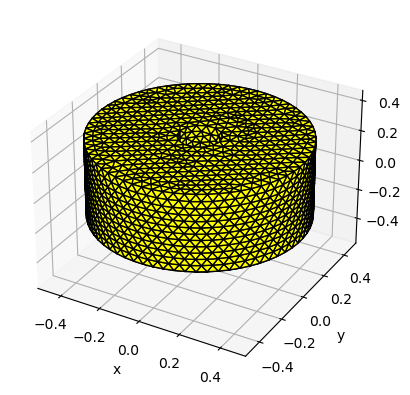

In [6]:
# show
float_fb.show_matplotlib()

# interactive, close pop-up image before being able to continue running the notebook
# float_fb.show()

#### Mesh creation of the spar

We now create the spar mesh in the same way as for the float, with the dimensions given by Oregon State University.

<p><img src=https://live.staticflickr.com/65535/52793722023_cd0b2e5d4f_k.jpg alt="spar dimensions schematic from OSU" width=700></p>

In [7]:
# mesh
mesh_size_factor = 0.1
r1 = 0.45/2  # body
r2 = 0.45  # plate
r3 = 0.10/2  # bar
h1 = 1.20  
h2 = 0.01
h3a = 3.684 - 2.05
submergence = 2.05 - h1 - h2

with pygmsh.occ.Geometry() as geom:
    gmsh.option.setNumber('Mesh.MeshSizeFactor', mesh_size_factor)
    body = geom.add_cylinder([0, 0, 0], [0, 0, -h1], r1)
    geom.translate(body, [0, 0, -submergence])
    plate = geom.add_cylinder([0, 0, 0], [0, 0, -h2], r2)
    geom.translate(plate, [0, 0, -(submergence+h1)])
    bar = geom.add_cylinder([0, 0, h3a], [0, 0, -(h3a+submergence)], r3)
    geom.boolean_union([bar, body, plate])
    mesh_spar = geom.generate_mesh()

In [8]:
# floating body
spar_fb = cpy.FloatingBody.from_meshio(mesh_spar, name='spar')
spar_fb.add_translation_dof(name='Heave')

(-0.44989582589095095, 0.4498958258909509)

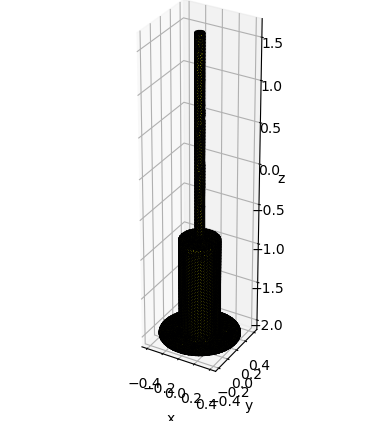

In [9]:
# show
fig = plt.figure()
xmin, xmax, ymin, ymax, zmin, zmax = spar_fb.mesh.axis_aligned_bbox
scalez = (zmax-zmin) / (xmax-xmin)
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect(aspect=(1,1,scalez))
spar_fb.show_matplotlib(ax=ax)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# interactive, close pop-up image before being able to continue running the notebook
# spar_fb.show()

#### Combined `FloatingBody`

With both WEC bodies defined separately, we should first define the respective centers of mass and rotation centers for the `FloatingBody`s. Then, we can create a union of the bodies and define the properties for the overall LUPA device. At the equilibrium position the float is neutrally buoyant while the spar is positively buoyant and requires mooring pre-tension. The combined center of mass and moment of inertia can be found by using the given values weighted by the mass (via the parallel axis theorem for the moment of inertia). This is also when we can specify the surge and pitch degrees of freedom.

We are using the density of *fresh* water, $\rho = 1000 kg/m^3$, since we are modeling LUPA in a wave flume.

In [10]:
# density of fresh water
rho = 1000

# mass properties float
mass_float = float_mass_properties['mass'] 
cm_float = np.array(float_mass_properties['CG'])
pitch_inertia_float = float_mass_properties['MOI'][1] 
float_fb.center_of_mass = cm_float
float_fb.rotation_center = float_fb.center_of_mass

# mass properties spar
mass_spar = spar_mass_properties['mass']  
cm_spar = np.array(spar_mass_properties['CG'])
pitch_inertia_spar = spar_mass_properties['MOI'][1] 
spar_fb.center_of_mass = cm_spar
spar_fb.rotation_center = spar_fb.center_of_mass

# floating body
lupa_fb = float_fb + spar_fb
lupa_fb.name = 'LUPA'

 # mass properties LUPA
lupa_fb.center_of_mass = ((mass_float*cm_float + mass_spar*cm_spar)
                        / (mass_float + mass_spar))
lupa_fb.rotation_center = lupa_fb.center_of_mass

# pitch moment of inertia of LUPA using the parallel axis theorem 
d_float = cm_float[2] - lupa_fb.center_of_mass[2]
d_spar = cm_spar[2] - lupa_fb.center_of_mass[2]
pitch_inertia = (
    pitch_inertia_float + mass_float*d_float**2 + 
    pitch_inertia_spar + mass_spar*d_spar**2
)
inertia = np.diag([mass_float, mass_spar, lupa_fb.disp_mass(), pitch_inertia])

# additional DOFs
lupa_fb.add_translation_dof(name='Surge')
lupa_fb.add_rotation_dof(name='Pitch')

#### Define Hydrostatics Manually

When combining multiple bodies, we need to be careful to set up the hydrostatics correctly. The bodies move separately in heave but move together in surge and pitch. Therefore, we should define the individual heave inertia values for each body and define the total surge and pitch inertia values. The inertia then needs to be reformatted as a DataArray for Capytaine. Lastly, the hydrostatic stiffness can be calculated for the total immersed body.

In [11]:
# reorganize inertia values into DataArray for Capytaine
rigid_inertia_matrix_xr = xr.DataArray(data=np.asarray((inertia)),
                            dims=['influenced_dof', 'radiating_dof'],
                            coords={'influenced_dof': list(lupa_fb.dofs),
                                    'radiating_dof': list(lupa_fb.dofs)},
                            name="inertia_matrix")

# Set FloatingBody inertia matrix
lupa_fb.inertia_matrix = rigid_inertia_matrix_xr

# Calculate hydrostatic stiffness after keeping immersed value
lupa_fb = lupa_fb.keep_immersed_part()
lupa_fb.hydrostatic_stiffness = lupa_fb.compute_hydrostatic_stiffness(rho=rho)

('float__Heave', 'float__Heave')
('spar__Heave', 'float__Heave')
('Surge', 'float__Heave')
('Pitch', 'float__Heave')
('float__Heave', 'spar__Heave')
('spar__Heave', 'spar__Heave')
('Surge', 'spar__Heave')
('Pitch', 'spar__Heave')
('float__Heave', 'Surge')
('spar__Heave', 'Surge')
('Surge', 'Surge')
('Pitch', 'Surge')
('float__Heave', 'Pitch')
('spar__Heave', 'Pitch')
('Surge', 'Pitch')
('Pitch', 'Pitch')


We can now visualize the combined mesh.

(-0.49988418146689506, 0.49991177824025046)

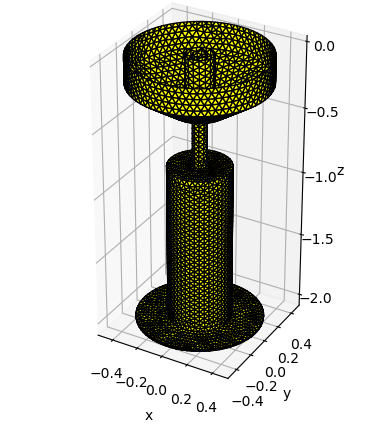

In [12]:
# show
fig = plt.figure()
xmin, xmax, ymin, ymax, zmin, zmax = lupa_fb.mesh.axis_aligned_bbox
scalez = (zmax-zmin) / (xmax-xmin)
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect(aspect=(1,1,scalez))
lupa_fb.show_matplotlib(ax=ax)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# lupa_fb.show()

### BEM
With the LUPA geometry and physical properties fully defined, we can now run Capytaine to calculate the hydrodynamic and hydrostatic coefficients of the device, as done in previous tutorials. Capytaine can handle generalized modes and will calculate the coefficients for our 4 degrees of freedom. Because we are now using irregular waves, we need significantly more frequencies to capture the entire wave spectrum. The BEM coefficients have been pre-calculated and are saved in a file. To re-run the BEM, which takes about 1 hour, simply move or delete the existing `data/bem.nc` file.

In [13]:
# compute hydrodynamic coefficients
f1 = 0.02
nfreq = 50
freq = wot.frequency(f1, nfreq, False)

# read BEM data file if it exists
filename = 'data/bem.nc'
try:
    bem_data = wot.read_netcdf(filename)
except:
    bem_data = wot.run_bem(lupa_fb, freq, rho=rho)
    wot.write_netcdf(filename, bem_data)

We now visualize the BEM results. An irregular frequency at about 5.25 rad/s is visible in many of the plots, but this should not substantially impact our model as the wave energy at this frequency is fairly low. 

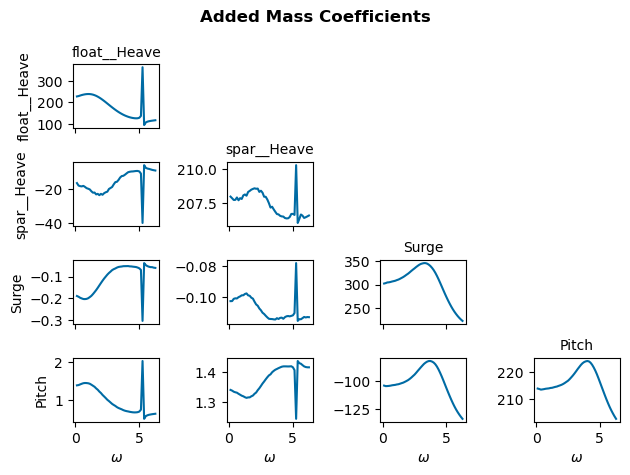

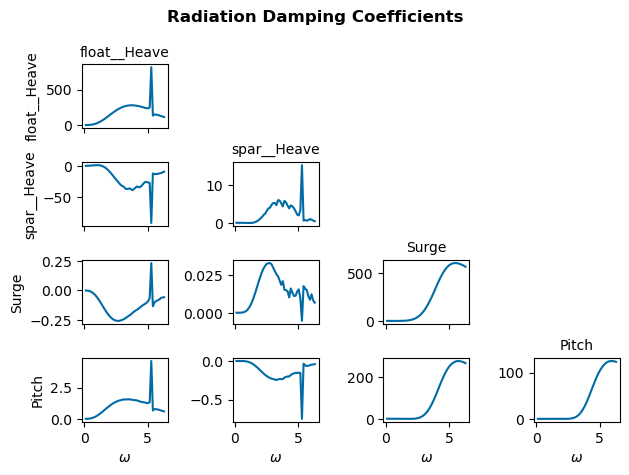

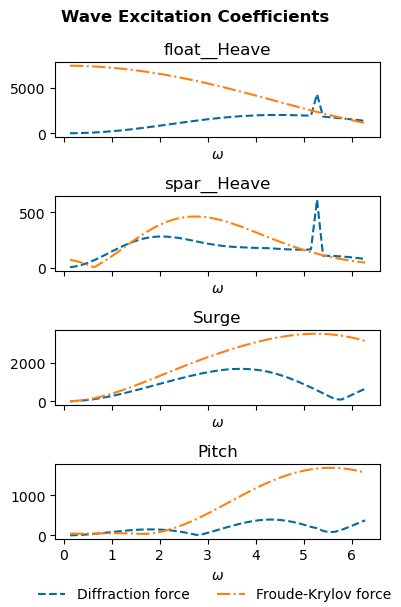

In [14]:
# plot coefficients
radiating_dofs = bem_data.radiating_dof.values
influenced_dofs = bem_data.influenced_dof.values

# plots
fig_am, ax_am = plt.subplots(len(radiating_dofs), len(influenced_dofs),
                             tight_layout=True, sharex=True)
fig_rd, ax_rd = plt.subplots(len(radiating_dofs), len(influenced_dofs),
                             tight_layout=True, sharex=True)
fig_ex, ax_ex = plt.subplots(len(influenced_dofs), 1,
                             tight_layout=True, sharex=True, figsize=(4, 6))

# plot titles
fig_am.suptitle('Added Mass Coefficients', fontweight='bold')
fig_rd.suptitle('Radiation Damping Coefficients', fontweight='bold')
fig_ex.suptitle('Wave Excitation Coefficients', fontweight='bold')

# subplotting across 4DOF
sp_idx = 0
for i, rdof in enumerate(radiating_dofs):
    for j, idof in enumerate(influenced_dofs):
        sp_idx += 1
        if i == 0:
            np.abs(bem_data.diffraction_force.sel(influenced_dof=idof)).plot(
                ax=ax_ex[j], linestyle='dashed', label='Diffraction force')
            np.abs(bem_data.Froude_Krylov_force.sel(influenced_dof=idof)).plot(
                ax=ax_ex[j], linestyle='dashdot', label='Froude-Krylov force')
            ex_handles, ex_labels = ax_ex[j].get_legend_handles_labels()
            ax_ex[j].set_title(f'{idof}')
            ax_ex[j].set_xlabel('')
            ax_ex[j].set_ylabel('')
        if j <= i:
            bem_data.added_mass.sel(
                radiating_dof=rdof, influenced_dof=idof).plot(ax=ax_am[i, j])
            bem_data.radiation_damping.sel(
                radiating_dof=rdof, influenced_dof=idof).plot(ax=ax_rd[i, j])
            if i == len(radiating_dofs)-1:
                ax_am[i, j].set_xlabel(f'$\omega$', fontsize=10)
                ax_rd[i, j].set_xlabel(f'$\omega$', fontsize=10)
                ax_ex[j].set_xlabel(f'$\omega$', fontsize=10)
            else:
                ax_am[i, j].set_xlabel('')
                ax_rd[i, j].set_xlabel('')
            if j == 0:
                ax_am[i, j].set_ylabel(f'{rdof}', fontsize=10)
                ax_rd[i, j].set_ylabel(f'{rdof}', fontsize=10)
            else:
                ax_am[i, j].set_ylabel('')
                ax_rd[i, j].set_ylabel('')
            if j == i:
                ax_am[i, j].set_title(f'{idof}', fontsize=10)
                ax_rd[i, j].set_title(f'{idof}', fontsize=10)
            else:
                ax_am[i, j].set_title('')
                ax_rd[i, j].set_title('')
        else:
            fig_am.delaxes(ax_am[i, j])
            fig_rd.delaxes(ax_rd[i, j])
fig_ex.legend(ex_handles, ex_labels, loc=(0.08, 0), ncol=2, frameon=False)

### PTO system

The PTO model is similar to the one developed in Tutorial 2 but using the values corresponding to the LUPA PTO. 
The main difference is that in the LUPA the gear ratio can be modified by changing the interchangeable sprocket for one with a different radius. 
The motivation here is that operation in different wave conditions or different control schemes might have different torque and speed requirements. 
Oregon State University has three sprockets of diameters 81.5mm (8MX-32S-36), 127.3mm (8MX-50S-36), 203.7mm (8MX-80S-36), but the manufacturer provides a fine selection of radius size in this range. 

The PTO system consists of a [generator](https://akribis-systems.s3-us-west-2.amazonaws.com/pdfs/catalogs/adr-b.pdf), the [interchangeable sprocket](https://assets.gates.com/content/dam/gates/home/knowledge-center/resource-library/catalogs/old-pc_carbon_manual17595_2011.pdf), and two [idler pulleys](https://dpk3n3gg92jwt.cloudfront.net/domains/gates.pt/pdf/77234200.pdf) driven by a belt.

<p><img src=https://live.staticflickr.com/65535/52793276361_ff6a78ce4f_k.jpg alt="Schematic of the PTO system showing dimensions and parts." width=740> <img src=https://live.staticflickr.com/65535/52793518059_5f4b559d2a_h.jpg alt="Digital rendering of the LUPA with PTO mechanism visible." width=458></p>

We start by defining all the manufacturer-specified components.

In [15]:
conv_d = 0.0254  # in -> m
conv_m = 0.453592  # lb -> kg
conv_moi = 0.453592 * 0.3048**2  # lb*ft^2 -> kg*m^2
conv_s = 2*np.pi / 60  # rpm -> rad/s

# sprocket
sprockets = {
    '8MX-32S-36': {
        'diameter': 3.208 * conv_d,
        'mass': 1.7 * conv_m,
        'MOI': 0.02 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-33S-36': {
        'diameter': 3.308 * conv_d,
        'mass':  3.31* conv_m,
        'MOI': 0.022 * conv_moi,
        'design': 'AF',
    },
    '8MX-34S-36': {
        'diameter': 3.409 * conv_d,
        'mass': 1.8 * conv_m,
        'MOI': 0.026 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-35S-36': {
        'diameter': 3.509 * conv_d,
        'mass': 3.51 * conv_m,
        'MOI': 0.029 * conv_moi,
        'design': 'AF',
    },
    '8MX-36S-36': {
        'diameter': 3.609 * conv_d,
        'mass': 2.1 * conv_m,
        'MOI': 0.032 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-37S-36': {
        'diameter': 3.709 * conv_d,
        'mass': 3.78 * conv_m,
        'MOI': 0.039 * conv_moi,
        'design': 'AF',
    },
    '8MX-38S-36': {
        'diameter': 3.810 * conv_d,
        'mass': 2.4 * conv_m,
        'MOI': 0.04 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-39S-36': {
        'diameter': 3.910 * conv_d,
        'mass': 3.91 * conv_m,
        'MOI': 0.048 * conv_moi,
        'design': 'AF',
    },
    '8MX-40S-36': {
        'diameter': 4.010 * conv_d,
        'mass': 2.5 * conv_m,
        'MOI': 0.049 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-41S-36': {
        'diameter': 4.110 * conv_d,
        'mass': 4.11 * conv_m,
        'MOI': 0.057 * conv_moi,
        'design': 'AF',
    },
    '8MX-42S-36': {
        'diameter': 4.211 * conv_d,
        'mass': 2.8 * conv_m,
        'MOI': 0.061 * conv_moi,
        'design': 'AF-1',  
    },
    '8MX-45S-36': {
        'diameter': 4.511 * conv_d,
        'mass': 3.8 * conv_m,
        'MOI': 0.09 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-48S-36': {
        'diameter': 4.812 * conv_d,
        'mass': 4.3 * conv_m,
        'MOI': 0.114 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-50S-36': {
        'diameter': 5.013 * conv_d,
        'mass': 5.1 * conv_m,
        'MOI': 0.143 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-53S-36': {
        'diameter': 5.314 * conv_d,
        'mass': 5.5 * conv_m,
        'MOI': 0.169 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-56S-36': {
        'diameter': 5.614 * conv_d,
        'mass': 6.5 * conv_m,
        'MOI': 0.221 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-60S-36': {
        'diameter': 6.015 * conv_d,
        'mass': 8.9 * conv_m,
        'MOI': 0.352 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-63S-36': {
        'diameter': 6.316 * conv_d,
        'mass': 10.4 * conv_m,
        'MOI': 0.556 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-67S-36': {
        'diameter': 6.717 * conv_d,
        'mass': 6.5 * conv_m,
        'MOI': 0.307 * conv_moi,
        'design': 'DF-1',
    },
    '8MX-71S-36': {
        'diameter': 7.118 * conv_d,
        'mass': 7.0 * conv_m,
        'MOI': 0.365 * conv_moi,
        'design': 'DF-1',
    },
    '8MX-75S-36': {
        'diameter': 7.519 * conv_d,
        'mass': 7.3 * conv_m,
        'MOI': 0.423 * conv_moi, 
        'design': 'DF-1',
    },
    '8MX-80S-36': {
        'diameter': 8.020 * conv_d,
        'mass': 17.9 * conv_m,
        'MOI': 1.202 * conv_moi,  
        'design': 'BF-1',
    },
}

# idler pulleys
idler_pulley = {
    'model': 'Gates 4.25X2.00-IDL-FLAT',
    'diameter': 4.25 * conv_d, 
    'face_width': 2.00 * conv_d,
    'mass': 7.6 * conv_m,
    'max_rpm': 5840,
    'MOI': None,  # Not specified
}

# generator
# Note: Model ADR220-B175 data not listed online, but we have
# spec sheet available on request 
generator = {
    'torque_constant': 8.51,  # N*m/A
    'winding_resistance': 5.87,  # Ω 
    'winding_inductance' : 0.0536,  # H 
    'max_torque': 137.9,  # N*m
    'continuous_torque': 46,  # N*m
    'max_speed': 150 * conv_s,  # rad/s
    'MOI': 1.786e-2,  # kg*m^2 
}

We then define the PTO based on these part specifications. 
For Part 1, where we are setting up the problem, we will use the mid-size sprocket of diameter 127.3mm (8MX-50S-36). 

In [16]:
# drivetrain 
def gear_ratio(pulley_radius):
    return 1/pulley_radius  # rad/m 

drivetrain_friction = 0.5  # N*m*s/rad  # this will be estimated experimentally in the future
drivetrain_stiffness = 0  # N*m/rad 
# estimated based on mass, assumed to be a disk:
idler_pulley['MOI'] = 0.5 * idler_pulley['mass'] * (idler_pulley['diameter']/2)**2  # kg*m^2

# impedance model
def pto_impedance(sprocket_model, omega=bem_data.omega.values):
    pulley_ratio = sprockets[sprocket_model]['diameter'] / idler_pulley['diameter']
    drivetrain_inertia = (
        generator['MOI'] + 
        sprockets[sprocket_model]['MOI'] + 
        2 * idler_pulley['MOI']*pulley_ratio**2
    )  # N*m^2
    drivetrain_impedance = (
        1j*omega*drivetrain_inertia + 
        drivetrain_friction + 
        1/(1j*omega)*drivetrain_stiffness
    ) 
    winding_impedance = (generator['winding_resistance']
                       + 1j*omega*generator['winding_inductance']
    )
    pulley_radius = sprockets[sprocket_model]['diameter'] / 2
    pto_impedance_11 = -1* gear_ratio(pulley_radius)**2 * drivetrain_impedance
    off_diag = -1*np.ones(omega.shape) * (
        np.sqrt(3.0/2.0) * generator['torque_constant'] * gear_ratio(pulley_radius) + 0j)
    pto_impedance_12 = off_diag 
    pto_impedance_21 = off_diag
    pto_impedance_22 = winding_impedance
    impedance = np.array([[pto_impedance_11, pto_impedance_12],
                          [pto_impedance_21, pto_impedance_22]])
    return impedance

# PTO object
name = ["PTO_Heave",]
kinematics = np.array([[1, -1, 0, 0],])
pto_ndof = 1
controller = None
loss = None
default_sprocket = '8MX-50S-36'
pto = wot.pto.PTO(pto_ndof,
                  kinematics,
                  controller,
                  pto_impedance(default_sprocket),
                  loss,
                  name)

### Constraints
In this tutorial we include realistic constraints on both the device motions and the generator operation:

* The **maximum stroke** (difference in heave between the float and spar) is 0.5m. Although there are end-stops (hard stop), the controller should ensure a soft stop. So, instead of modeling the hard stop we will add a constraint. 
* The generator has both a **maximum torque** and **maximum speed**. It is important that we do not exceed that during operation.
* Generators also have a **continuous torque** requirement. The RMS torque during operation should not exceed this value or we risk damage to and failure of the machine. The torque can go higher that this (up to the maximum) for brief periods as long as the RMS torque remains below this threshold. 

We enforce all these through constraints on our design optimization problem. 

In [17]:
## Displacements
# maximum stroke
stroke_max = 0.5  # m
def const_stroke_pto(wec, x_wec, x_opt, waves): 
    pos = pto.position(wec, x_wec, x_opt, waves, nsubsteps)
    return stroke_max - np.abs(pos.flatten())

## GENERATOR
# peak torque
default_radius = sprockets[default_sprocket]['diameter'] / 2
def const_peak_torque_pto(wec, x_wec, x_opt, waves, radius=default_radius): 
    """Instantaneous torque must not exceed max torque Tmax - |T| >=0 
    """
    torque = pto.force(wec, x_wec, x_opt, waves, nsubsteps) / gear_ratio(radius)
    return generator['max_torque'] - np.abs(torque.flatten())

# continuous torque
def const_torque_pto(wec, x_wec, x_opt, waves, radius=default_radius): 
    """RMS torque must not exceed max continous torque 
        Tmax_conti - Trms >=0 """
    torque = pto.force(wec, x_wec, x_opt, waves, nsubsteps) / gear_ratio(radius)
    torque_rms = np.sqrt(np.mean(torque.flatten()**2))
    return generator['continuous_torque'] - torque_rms

# max speed
def const_speed_pto(wec, x_wec, x_opt, waves, radius=default_radius): 
    rot_vel = pto.velocity(wec, x_wec, x_opt, waves, nsubsteps) * gear_ratio(radius)
    return generator['max_speed'] - np.abs(rot_vel.flatten())

## Constraints
constraints = [
    {'type': 'ineq', 'fun': const_stroke_pto},
    {'type': 'ineq', 'fun': const_peak_torque_pto},
    {'type': 'ineq', 'fun': const_torque_pto},
    {'type': 'ineq', 'fun': const_speed_pto},
]
nsubsteps = 5

### Mooring system
To fully capture the dynamics acting on LUPA in the Large Wave Flume, we must model the mooring system being used to account for the restoring forces acting on the WEC. The LUPA setup uses a 4-line taut mooring system with springs connecting the spar to the wall of the wave flume. The following mooring system properties have been provided by Oregon State University. The initial fairlead coordinates and anchor coordinates are relative to the center of gravity of the combined device:

In [18]:
pretension = 285 # N
init_fair_coords = np.array([[-0.19, -0.19, -0.228],
                             [-0.19,  0.19, -0.228],
                             [ 0.19, -0.19, -0.228],
                             [ 0.19,  0.19, -0.228]]) # m
anch_coords = np.array([[-1.95, -1.6, -0.368],
                        [-1.95,  1.6, -0.368],
                        [ 1.95, -1.6, -0.368],
                        [ 1.95,  1.6, -0.368]]) # m
line_ax_stiff = 963. # N/m

There are several analytical and numerical methods commonly used to model mooring system kinematics for offshore systems, ranging from static analysis to determine equilibrium forces, all the way to FEA used to calculate the fully dynamic response of the mooring system components. For this design problem, we're mostly concerned with modeling the correct response of LUPA due to operational waves, so the high-fidelity methods are unnecessary at this design stage. While a purely linearized approach is common here, the symmetry of the taut lines in this current system allows us to instead use an analytical solution derived by Al-Solihat and Nahon (https://doi.org/10.1080/17445302.2015.1089052), which allows us to capture nonlinear mooring effects and off-diagonal terms in the mooring stiffness matrix without any significant increase in computation time.

This solution takes an exact analysis of the derivatives of the classic elastic catenary equations and simplifies them by assuming the taut lines have no sag and negligible mass, allowing for the differential changes of the horizontal and vertical restoring force to be calculated as
$$ \frac{\partial F_{hor}}{\partial l} = K_{axial}\textup{cos}^2 \theta + \frac{T}{L} \textup{sin}^2 \theta $$
$$ \frac{\partial F_{vert}}{\partial h} = K_{axial}\textup{sin}^2 \theta + \frac{T}{L} \textup{cos}^2 \theta $$
$$ \frac{\partial F_{hor}}{\partial h} = \frac{\partial F_{vert}}{\partial l} = \textup{cos} \theta \textup{sin} \theta \left [ K_{axial}- \frac{T}{L}\right ]$$

where $l$ and $h$ are the horizontal and vertical distance between the anchor points and fairlead points, respectively; $T$ is the pretension; $\theta$ is the angle between the seabed and the mooring line such that $ \theta = \textup{tan}^{-1}(\frac{h}{l}) $; and $L$ is the stretched length of the mooring line such that $L = \sqrt{l^2 + h^2} $

When these equations are applied to the linear stiffness equation in each radiating ($i$) and influencing ($j$) degrees of freedom:
$$\boldsymbol{K_{mooring}} = - \frac{\partial \boldsymbol{F_{mooring}}}{\partial \boldsymbol{X}} = \sum_{m=1}^{n_{lines}}  [K_{ij}]^{(m)} = - \sum_{m=1}^{n_{lines}}[\frac{\partial (F_{mooring})_i}{\partial X_j}]^{(m)} $$
where $X$ are the generalized displacements of the WEC in each degree of freedom, they yield Equation (27) from the reference above which provides an analytical solution to the mooring stiffness matrix, which translates to the `k_mooring` function below. See the reference above for the full theoretical explanation and derivation of these equations.

In [19]:
# mooring matrix
def k_mooring(fair_coords, anch_coords, pretension, k_ax, nlines):
    """Calculates the 7DOF effective stiffness matrix of a symmetric taut
    mooring system using an analytical solution.
    """

    theta = np.arctan(
        (fair_coords[2] - anch_coords[2])**2
      / np.sqrt(((fair_coords[0] - anch_coords[0])**2
               + (fair_coords[1] - anch_coords[1])**2)))
    linelen = np.sqrt((fair_coords[0] - anch_coords[0])**2
                + (fair_coords[1] - anch_coords[1])**2
                + (fair_coords[2] - anch_coords[2])**2)
    fair_r = np.sqrt(fair_coords[0]**2 + fair_coords[1]**2)
    fair_z = -fair_coords[2]
    k_hh = 0.5 * nlines * (
        pretension / linelen * (1 + np.sin(theta)**2)
        + k_ax * np.cos(theta)**2)
    k_rh = nlines * (
        pretension / (2*linelen) * (fair_z * (1 + np.sin(theta)**2)
        + fair_r * np.sin(theta) * np.cos(theta))
        + 0.5 * k_ax * (fair_z * np.cos(theta)**2
        - fair_r * np.sin(theta) * np.cos(theta)))
    k_vv = nlines * (pretension / linelen *
        np.cos(theta)**2 + k_ax * np.sin(theta)**2)
    k_rr = nlines * (
        pretension * (fair_z * np.sin(theta) + 0.5 * fair_r * np.cos(theta))
        + (0.5 * pretension / linelen * ((fair_r * np.cos(theta) + fair_z * np.sin(theta))**2
        + fair_z**2))
        + 0.5 * k_ax * (fair_z * np.cos(theta) - fair_r*np.sin(theta))**2)
    k_tt = nlines * (
        pretension * fair_r / linelen * (fair_r + linelen*np.cos(theta)))
    mat = np.zeros([7, 7])
    mat[1, 1] = k_vv
    mat[2, 2] = k_hh
    mat[3, 3] = k_hh
    mat[4, 4] = k_rr
    mat[5, 5] = k_rr
    mat[6, 6] = k_tt
    mat[2, 5] = -k_rh
    mat[5, 2] = -k_rh
    mat[4, 3] = k_rh
    mat[3, 4] = k_rh

    return mat

`k_mooring` defines the 7x7 mooring matrix for a two-body point absorber WEC. Since we are only concerned with the planar components here, we can extract the rows/columns for the heaves, surge, and pitch to obtain the 4x4 matrix we need here.

In [20]:
M = k_mooring(init_fair_coords[0, :], anch_coords[0, :], pretension,
              line_ax_stiff, init_fair_coords.shape[0])
ind_4dof = np.array([0, 1, 2, 5])
M_4dof = M[np.ix_(ind_4dof, ind_4dof)]
print(M_4dof)

[[   0.            0.            0.            0.        ]
 [   0.          504.79122981    0.            0.        ]
 [   0.            0.         2178.14277582 -492.70812497]
 [   0.            0.         -492.70812497  285.08177521]]


Finally, with some more formatting, we can translate the mooring force into the format expected from WecOptTool by treating the mooring matrix as a transfer function and defining it via the `wecopttool.force_from_rao_transfer_function()` function, which multiplies the position of the WEC by the mooring matrix and return the restoring force.

In [21]:
# mooring
M = xr.DataArray(M_4dof,
                 coords=[bem_data.coords['influenced_dof'],
                 bem_data.coords['radiating_dof']],
                 dims=['influenced_dof', 'radiating_dof'])
moor = ((M + 0j).expand_dims({"omega": bem_data.omega}))
tmp = moor.isel(omega=0).copy(deep=True)
tmp['omega'] = tmp['omega'] * 0
moor = xr.concat([tmp, moor], dim='omega') 
moor = moor.transpose("omega", "radiating_dof", "influenced_dof")
moor = -1*moor  # RHS of equation: -ma = Σf 
mooring_force = wot.force_from_rao_transfer_function(moor, True)

#### Pre-tension of spar

The spar is positively buoyant at its equilibrium position and relies on pre-tension from the mooring. 
The mooring matrix above only captures the restoring forces from the mooring lines, not the pretension itself. 
Here we have two choices:

1. We can ignore this fact. WecOptTool asssumes equilibrium so the pre-tension force is implied. 
2. Explicitly model the buoyancy, gravity, and pre-tension forces as done in Tutorial 2. 

In Tutorial 2 we had constraints on the mooring/tether line (minimum tension, never slack) and therefore it was important to explicitly model these forces. In this case we do not have such constraints and will simply allow to pre-tension force to be implied. This does not affect the solution.

### WEC object

We are now ready to create our full WEC object. 

In [22]:
# additional forces
f_add = {
    'PTO': pto.force_on_wec,
    'Mooring': mooring_force
}

# small amount of friction to avoid small/negative terms
friction = np.diag([2.0, 2.0, 2.0, 0])

# WEC
wec = wot.WEC.from_bem(bem_data,
                       constraints=constraints,
                       friction=friction,
                       f_add=f_add,
                       dof_names=bem_data.influenced_dof.values,
)

### Waves
Oregon State University has defined two sets of wave testing conditions for the LUPA: one corresponding to the PacWave South site and a scaling factor of 25, and one for the PacWave North site and a scaling factor of 20. 
For each site/scale they provide four wave conditions to test at the Oregon State Large Wave Flume (LWF): the maximum 90<sup>th</sup> percentile, maximum percent annual energy, maximum occurrence, and minimum 10<sup>th</sup> percentile. 

In this tutorial we will use the PacWave South conditions scaled to the LWF and will design for the maximum occurrence wave. 
The wave conditions are specified in terms of significant wave height and peak period. Waves are mostly fully developed at the PacWave site, so we will use a Pierson-Moskowitz wave spectrum.

In [23]:
waves = {}

# regular (for testing/setup)
amplitude = 0.1
wavefreq = 0.4
phase = 0
wavedir = 0
waves['regular'] = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

# irregular wave cases from OSU
wave_cases = {
    'south_max_90': {'Hs': 0.21, 'Tp': 3.09}, 
    'south_max_annual': {'Hs': 0.13, 'Tp': 2.35},
    'south_max_occurrence': {'Hs': 0.07, 'Tp': 1.90},
    'south_min_10': {'Hs': 0.04, 'Tp': 1.48},  
    'north_max_90': {'Hs': 0.25, 'Tp': 3.46}, 
    'north_max_annual': {'Hs': 0.16, 'Tp': 2.63},
    'north_max_occurrence': {'Hs': 0.09, 'Tp': 2.13},
    'north_min_10': {'Hs': 0.05, 'Tp': 1.68}, 
}

def irregular_wave(hs, tp):
    fp = 1/tp
    spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, hs)
    efth = wot.waves.omnidirectional_spectrum(f1, nfreq, spectrum, "Pierson-Moskowitz")
    return wot.waves.long_crested_wave(efth,nrealizations=100)

for case, data in wave_cases.items():
    waves[case] = irregular_wave(data['Hs'], data['Tp'])

We now plot the wave spectra in order to verify that our frequency array is sufficient to capture our target waves. The peak frequency for the PacWave South maximum occurrence is cut off somewhat, so we would want to sample more wave frequencies (i.e. increase `nfreq`) in a formal analysis to properly capture this. However, this is sufficient for purposes of this tutorial.

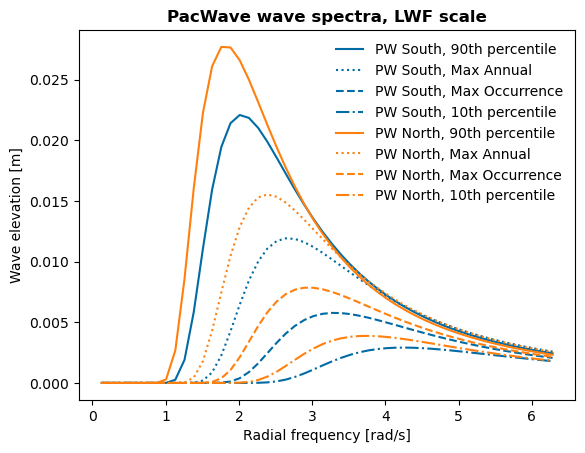

In [24]:
fig, ax = plt.subplots()
plt1 = np.abs(waves['south_max_90'].sel(realization=0)).plot(
    ax=ax, color='C0', linestyle='solid', label='PW South, 90th percentile')
plt2 = np.abs(waves['south_max_annual'].sel(realization=0)).plot(
    ax=ax, color='C0', linestyle='dotted', label='PW South, Max Annual')
plt3 = np.abs(waves['south_max_occurrence'].sel(realization=0)).plot(
    ax=ax, color='C0', linestyle='dashed', label='PW South, Max Occurrence')
plt4 = np.abs(waves['south_min_10'].sel(realization=0)).plot(
    ax=ax, color='C0', linestyle='dashdot', label='PW South, 10th percentile')
plt5 = np.abs(waves['north_max_90'].sel(realization=0)).plot(
    ax=ax, color='C1', linestyle='solid', label='PW North, 90th percentile')
plt6 = np.abs(waves['north_max_annual'].sel(realization=0)).plot(
    ax=ax, color='C1', linestyle='dotted', label='PW North, Max Annual')
plt7 = np.abs(waves['north_max_occurrence'].sel(realization=0)).plot(
    ax=ax, color='C1', linestyle='dashed', label='PW North, Max Occurrence')
plt8 = np.abs(waves['north_min_10'].sel(realization=0)).plot(
    ax=ax, color='C1', linestyle='dashdot', label='PW North, 10th percentile')

ax.set_title('PacWave wave spectra, LWF scale', fontweight='bold')
plts = plt1 + plt2 + plt3 + plt4 + plt5 + plt6 + plt7 + plt8
ax.legend(plts, [pl.get_label() for pl in plts], ncols=1, frameon=False)

### Solve
We now solve the inner optimization for optimal control strategy for a fixed design.

In a formal design case, it is good practice to first test the setup with a regular wave case to confirm the WEC is responding as expected. We have performed this step, but skip it here for the sake of brevity. To run the regular wave, change the wave selection in the code below. 

In [25]:
# Objective function
obj_fun = pto.average_power
nstate_opt = wec.ncomponents

# Solve
scale_x_wec = 1e1
scale_x_opt = 1e-3
scale_obj = 1e-2

results = wec.solve(
    waves['south_max_occurrence'],
    # waves['regular'], 
    obj_fun, 
    nstate_opt, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
)
power_results = [result.fun for result in results]
x_results = [result.x for result in results]
print(f'Optimal average electrical power: {np.mean(power_results)} W')

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.011328214971438287
            Iterations: 54
            Function evaluations: 55
            Gradient evaluations: 54
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.011327313557387857
            Iterations: 53
            Function evaluations: 54
            Gradient evaluations: 53
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.011326779626971917
            Iterations: 52
            Function evaluations: 53
            Gradient evaluations: 52
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.011326476224736487
            Iterations: 52
            Function evaluations: 53
            Gradient evaluations: 52
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.011326684821730229
            Iterations: 52
         

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.011326528906861635
            Iterations: 52
            Function evaluations: 53
            Gradient evaluations: 52
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.011326232149660102
            Iterations: 52
            Function evaluations: 53
            Gradient evaluations: 52
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.011326637793812875
            Iterations: 52
            Function evaluations: 53
            Gradient evaluations: 52
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.011326581090367518
            Iterations: 52
            Function evaluations: 53
            Gradient evaluations: 52
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.011326590743826954
            Iterations: 52
         

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.011326442477931964
            Iterations: 52
            Function evaluations: 53
            Gradient evaluations: 52
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.011326340158719644
            Iterations: 52
            Function evaluations: 53
            Gradient evaluations: 52
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.011326661111512924
            Iterations: 52
            Function evaluations: 53
            Gradient evaluations: 52
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.011327474073656417
            Iterations: 53
            Function evaluations: 54
            Gradient evaluations: 53
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.011326375943310086
            Iterations: 52
         

Text(0, 0.5, 'Average Power (W)')

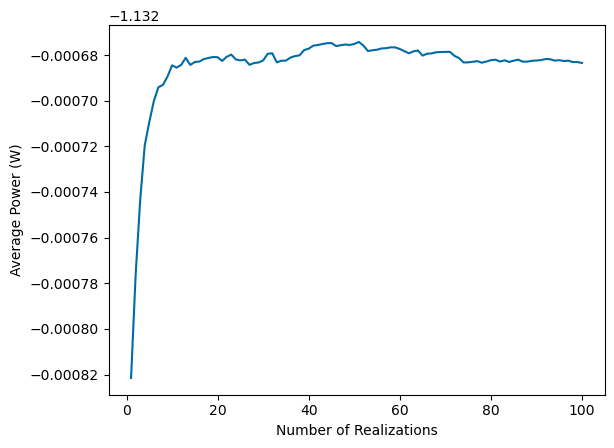

In [26]:
rolling_mean = []

for ind in range(len(power_results)):
    rolling_mean.append(np.mean(power_results[0:ind+1]))
    
plt.figure()
plt.plot(range(1,len(power_results)+1),rolling_mean)
plt.xlabel('Number of Realizations')
plt.ylabel('Average Power (W)')

In [27]:
import xarray as xr
res_ds = xr.Dataset(data_vars = dict(power=(['ind'],power_results),x=(['ind','ind2'],x_results)), 
                    coords=dict(ind=range(len(power_results)),ind2=range(len(x_results[0]))))
res_ds.to_netcdf('LUPA_power_convergence.nc')

In [28]:
x_wec, x_opt = wec.decompose_state(results[0].x)
print(len(x_opt))

100


In [29]:
# Post-process
nsubsteps = 5
wec_fdom, wec_tdom = wec.post_process(results[0], waves['south_max_occurrence'].sel(realization=0), nsubsteps)
pto_fdom, pto_tdom = pto.post_process(wec, results[0], waves['south_max_occurrence'].sel(realization=0), nsubsteps)

### Results
Looking at the response of the optimal solution, we can see the behavior of the WEC and its relationship to our problem constraints:

* __PTO position__ - The PTO position corresponds to the difference in the vertical position between the two bodies. The PTO position is clearly nowhere near the 0.5 maximum stroke, so the constraint is not plotted here.
* __Excitation force and velocity__ - Much like Tutorial 2, we would expect the excitation force and velocity of each body to be in phase when maximizing for mechanical power and in the absence of constraints. Given the constraints on the PTO, this is not the case here, with the spar velocity being out of phase with the wave excitation acting on it. This indicates the differences when maximizing for mechanical vs. electrical power for LUPA in these wave conditions. It is also clear that the velocities (or their rotational equivalents) are nowhere near the generator maximum speed.
* __Generator torque__ - This plot shows that both of the torque constraints are active for this wave case, and dominate the solution given the lack of relevance of the other constraints above. The PTO RMS torque is well within the continuous torque limit, and the generator exceeds the RMS limit for only brief period. The peak torque limit is approached at a few moments as well.
* __Power__ - As expected, the greatest power absorption aligns with the times of greatest PTO velocity and peak torque magnitude. 

(-14.229991589165998, 2.533532541855421)

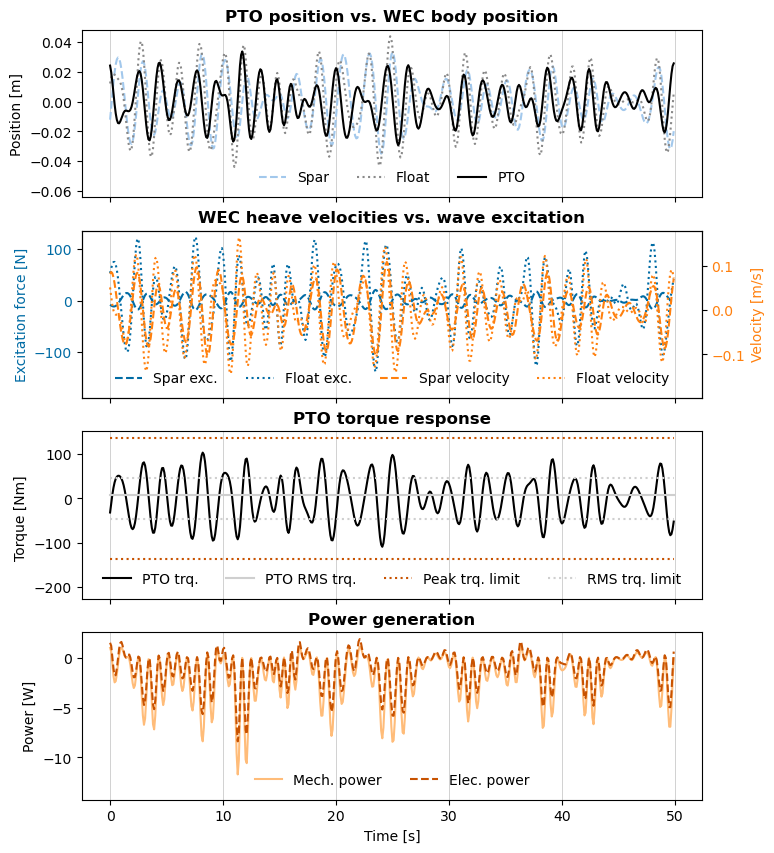

In [30]:
fig_res1, ax_res1 = plt.subplots(nrows=4, sharex=True, figsize=(8, 10))

## PTO position
wec_tdom.pos.sel(influenced_dof='spar__Heave').plot(
    ax=ax_res1[0], linestyle='dashed', color='C7', label='Spar')
wec_tdom.pos.sel(influenced_dof='float__Heave').plot(
    ax=ax_res1[0], linestyle='dotted', color='C6', label='Float')
pto_tdom.pos.plot(ax=ax_res1[0], label='PTO', color='black')

ax_res1[0].set_ylabel('Position [m]')
ax_res1[0].set_title('PTO position vs. WEC body position', fontweight='bold')
ax_res1[0].legend(ncols=3, loc='lower center', frameon=False)
ax_res1[0].grid(color='0.75', linestyle='-', linewidth=0.5, axis='x')
ax_res1[0].set_xlabel('')
ax_res1[0].set_ylim(bottom=ax_res1[0].get_ylim()[0]*1.33)

## Excitation and velocity
twinax = ax_res1[1].twinx()

# Spar excitation
force_excitation_spar = wec_tdom.force.sel(
    influenced_dof='spar__Heave', type=['Froude_Krylov', 'diffraction'])
force_excitation_spar = force_excitation_spar.sum('type')
plt1 = force_excitation_spar.plot(
    ax=ax_res1[1], linestyle='dashed', color='C0', label='Spar exc.')

# Float excitation
force_excitation_float = wec_tdom.force.sel(
    influenced_dof='float__Heave', type=['Froude_Krylov', 'diffraction'])
force_excitation_float = force_excitation_float.sum('type')
plt2 = force_excitation_float.plot(
    ax=ax_res1[1], linestyle='dotted', color='C0', label='Float exc.')

# Spar/float velocity
plt3 = wec_tdom.vel.sel(influenced_dof='spar__Heave').plot(
    ax=twinax, color='C1', linestyle='dashed', label='Spar velocity')
plt4 = wec_tdom.vel.sel(influenced_dof='float__Heave').plot(
    ax=twinax, color='C1', linestyle='dotted', label='Float velocity')

twinax.set_ylabel('Velocity [m/s]', color='C1')
twinax.tick_params(axis='y', labelcolor='C1')
twinax.set_title('')
twinax.autoscale(enable=True, axis='x', tight=False)
ax_res1[1].set_ylabel('Excitation force [N]', color='C0')
ax_res1[1].tick_params(axis='y', labelcolor='C0')
plts = plt1 + plt2 + plt3 + plt4
ax_res1[1].legend(plts, [pl.get_label() for pl in plts], ncols=4, loc='lower center', frameon=False)
ax_res1[1].set_title('WEC heave velocities vs. wave excitation', fontweight='bold')
ax_res1[1].grid(color='0.75', linestyle='-', linewidth=0.5, axis='x')
ax_res1[1].set_xlabel('')
ax_res1[1].set_ylim(bottom=ax_res1[1].get_ylim()[0]*1.25)
twinax.set_ylim(bottom=twinax.get_ylim()[0]*1.25)

## Torque
pto_tdom.force.plot(
    ax=ax_res1[2], linestyle='solid', color='black', label='PTO trq.')
pto_rms_tq  = np.sqrt(np.mean(pto_tdom.force.values**2)
                    / pto_tdom.time.values[-1])
ax_res1[2].plot(
    pto_tdom.time, pto_rms_tq * np.ones(pto_tdom.time.shape),
    color='C9', linestyle='solid', label='PTO RMS trq.')
max_tq = generator['max_torque']
rms_tq = generator['continuous_torque']
ax_res1[2].plot(
    pto_tdom.time, 1*max_tq * np.ones(pto_tdom.time.shape),
    color='C5', linestyle='dotted', label=f'Peak trq. limit')
ax_res1[2].plot(
    pto_tdom.time, -1*max_tq * np.ones(pto_tdom.time.shape),
    color='C5', linestyle='dotted')
ax_res1[2].plot(
    pto_tdom.time, 1*rms_tq * np.ones(pto_tdom.time.shape),
    color='C9', linestyle='dotted', label=f'RMS trq. limit')
ax_res1[2].plot(
    pto_tdom.time, -1*rms_tq * np.ones(pto_tdom.time.shape),
    color='C9', linestyle='dotted')
ax_res1[2].set_ylabel('Torque [Nm] ')
ax_res1[2].legend(ncols=4, loc='lower center', frameon=False)
ax_res1[2].set_title('PTO torque response', fontweight='bold')
ax_res1[2].grid(color='0.75', linestyle='-', linewidth=0.5, axis='x')
ax_res1[2].set_xlabel('')
ax_res1[2].set_ylim(bottom=ax_res1[2].get_ylim()[0]*1.5)

## Power
(pto_tdom['power'].loc['mech',:,:]).plot(
    ax=ax_res1[3], color='C8', label='Mech. power')
(pto_tdom['power'].loc['elec',:,:]).plot(
    ax=ax_res1[3], color='C5', linestyle='dashed', label="Elec. power")
ax_res1[3].legend(ncols=2, loc='lower center', frameon=False)
ax_res1[3].set_title('Power generation', fontweight='bold')
ax_res1[3].grid(color='0.75', linestyle='-', linewidth=0.5, axis='x')
ax_res1[3].set_ylabel('Power [W]')
ax_res1[3].set_ylim(bottom=ax_res1[3].get_ylim()[0]*1.15)

We can also look at all four degrees of freedom and make sure the relationships between the forces in each direction are reasonable. We can see that the PTO and radiation forces are generally in phase in the heave direction, but inversely related for the spar. We also see that the mooring response is inversely propotional to the radiation forces of the spar (with a more delayed restoring response in pitch than in surge/heave), and that the mooring correctly has no effect on the float, which it doesn't connect to.

Text(0.5, 0.93, 'WEC Forces')

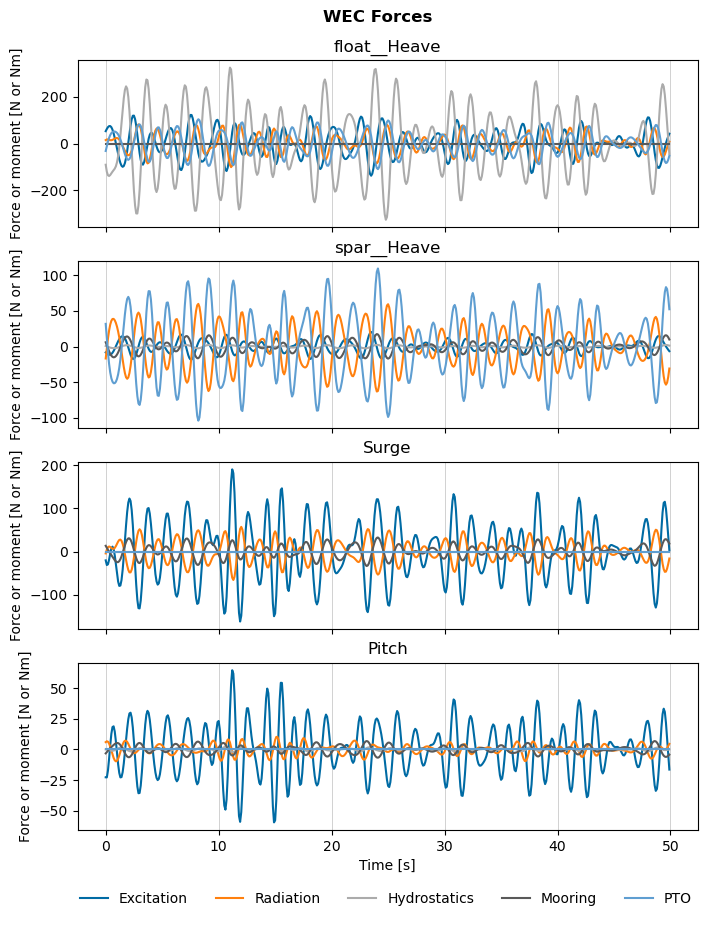

In [31]:
## Forces
fig_res2, ax_res2 = plt.subplots(len(influenced_dofs), 1, sharex=True, figsize=(8, 10))
for j, idof in enumerate(influenced_dofs):
    force_excitation = wec_tdom.force.sel(
        type=['Froude_Krylov', 'diffraction'])
    force_excitation = force_excitation.sum('type')
    force_excitation.sel(influenced_dof=idof).plot(
        ax=ax_res2[j], label='Excitation')
    wec_tdom.force.sel(influenced_dof=idof, type='radiation').plot(
        ax=ax_res2[j], label='Radiation')
    wec_tdom.force.sel(influenced_dof=idof, type='hydrostatics').plot(
        ax=ax_res2[j], label='Hydrostatics')
    wec_tdom.force.sel(influenced_dof=idof, type='Mooring').plot(
        ax=ax_res2[j], label='Mooring')
    wec_tdom.force.sel(influenced_dof=idof, type='PTO').plot(
        ax=ax_res2[j], label='PTO')
    ax_res2[j].set_title(f'{idof}')
    if j != len(influenced_dofs)-1:
        ax_res2[j].set_xlabel('')
    ax_res2[j].grid(color='0.75', linestyle='-', linewidth=0.5, axis='x')
handles_res2, labels_res2 = ax_res2[j].get_legend_handles_labels()
fig_res2.legend(handles_res2, labels_res2, loc=(0.105, 0.02), ncol=5, frameon=False)
fig_res2.suptitle('WEC Forces', fontweight='bold', y=0.93)

## 2. Control co-design of the PTO sprocket sizing for maximum electrical power

### Setup
With our model working as expected, we can now iterate on this model with varying sprocket sizing to identify the optimal size. As with previous tutorials, we wrap the code from Part 1 into a function and iterate on our chosen design parameter (i.e. each key of the `sprockets` dictionary earlier corresponds to the `x` argument of `design_obj_fun`)

In [32]:
def design_obj_fun(x):
    global n
    n += 1

    # Unpack sprocket name
    x = x.squeeze()
    sprocket = list(sprockets.keys())[x]
    spr_rad = sprockets[sprocket]['diameter'] / 2
    spr_mass = sprockets[sprocket]['mass']
    spr_moi = sprockets[sprocket]['MOI']
    spr_des = sprockets[sprocket]['design']

    # PTO object for given sprocket
    pto = wot.pto.PTO(pto_ndof, kinematics, controller, pto_impedance(sprocket), loss, name)
    
    ## Constraints
    # Maximum stroke
    stroke_max = 0.5  # m
    def const_stroke_pto(wec, x_wec, x_opt, waves): 
        pos = pto.position(wec, x_wec, x_opt, waves, nsubsteps)
        return stroke_max - np.abs(pos.flatten())

    ## GENERATOR
    # peak torque
    radius = sprockets[sprocket]['diameter'] / 2
    def const_peak_torque_pto(wec, x_wec, x_opt, waves): 
        """Instantaneous torque must not exceed max torque Tmax - |T| >=0 
        """
        torque = pto.force(wec, x_wec, x_opt, waves, nsubsteps) / gear_ratio(radius)
        return generator['max_torque'] - np.abs(torque.flatten())

    # continuous torque
    def const_torque_pto(wec, x_wec, x_opt, waves): 
        """RMS torque must not exceed max continous torque 
            Tmax_conti - Trms >=0 """
        torque = pto.force(wec, x_wec, x_opt, waves, nsubsteps) / gear_ratio(radius)
        torque_rms = np.sqrt(np.mean(torque.flatten()**2))
        return generator['continuous_torque'] - torque_rms

    # max speed
    def const_speed_pto(wec, x_wec, x_opt, waves): 
        rot_vel = pto.velocity(wec, x_wec, x_opt, waves, nsubsteps) * gear_ratio(radius)
        return generator['max_speed'] - np.abs(rot_vel.flatten())

    ## Constraints
    constraints = [
        {'type': 'ineq', 'fun': const_stroke_pto},
        {'type': 'ineq', 'fun': const_peak_torque_pto},
        {'type': 'ineq', 'fun': const_torque_pto},
        {'type': 'ineq', 'fun': const_speed_pto},
    ]

    # additional forces
    f_add = {
        'PTO': pto.force_on_wec,
        'Mooring': mooring_force
    }

    # create WEC object
    wec = wot.WEC.from_bem(bem_data,
                           constraints=constraints,
                           friction=friction,
                           f_add=f_add,
    )

    # Objective function
    obj_fun = pto.average_power 

    print(
        f'\nRun {n} of {N}: Sprocket {sprocket}\n' +
        f'   Sprocket diameter: {spr_rad*2} m\n' +
        f'   Sprocket mass: {spr_mass} kg\n' +
        f'   Sprocket moment of inertia: {spr_moi} kg-m^2\n' +
        f'   Sprocket design: {spr_des}')

    results = wec.solve(
        waves['south_max_occurrence'],
        # waves['regular'], 
        obj_fun, 
        nstate_opt, 
        scale_x_wec=scale_x_wec,
        scale_x_opt=scale_x_opt,
        scale_obj=scale_obj,
    )
    print(f'Optimal average electrical power: {results[0].fun:.2f} W')
    x_wec, x_opt = wec.decompose_state(results[0].x)
    x_wec_jac , x_opt_jac = wec.decompose_state(results[0].jac)
    ds = xr.Dataset(data_vars=dict(
        x_wec=('wec_state', x_wec),
        x_opt=('opt_state', x_opt),
        x_wec_jac=('wec_state', x_wec_jac),
        x_opt_jac=('opt_state', x_opt_jac),
        fval=results[0].fun),
        coords=dict(
        wec_state=range(wec.nstate_wec),
        opt_state=range(nstate_opt))
    )
    wot.write_netcdf(os.path.join(dir, 'data', f'tutorial_3_results_{x}.nc'), ds)
    return results[0].fun

Given there are only 22 sprockets, we will continue to use a brute force algorithm. This algorithm typically takes several hours to run; for sake of time here, we have included the calculated results in the `tutorial_3_results.nc` file. If you would like to run the brute force algorithm yourself (e.g. if you modify this notebook and would like to see how the results change), move or delete this file from the `data` directory.

In [33]:
global n; n = 0 
global N; N = len(sprockets)
ranges = slice(0, N, 1),

# solve
filename = 'data/tutorial_3_results.nc'
try:
    opt_results = wot.read_netcdf(filename)
except:
    combined_results = []
    _ = brute(
        func=design_obj_fun,
        ranges=ranges,
        full_output=True,
        finish=None)
    for x in range(N):
        run_filename = os.path.join(dir, 'data', f'tutorial_3_results_{x}.nc')
        combined_results.append(wot.read_netcdf(run_filename))
        os.remove(run_filename)
    opt_results = xr.concat(combined_results, dim='x0s')
    wot.write_netcdf(filename, opt_results)

### Results
The power generation for all the sprockets are plotted below, with the three sprockets possessed by Oregon State University called out. Comparing the results across the range of sprocket sizes, it is clear that power generation is maximized towards smaller sprocket diameters. Here, 8MX-33S-36 sprocket (wiht the second smallest diameter) is the best sprocket selection for LUPA for the selected wave case.

The motivation to include an interchangeable sprocket in LUPA is to make it versatile across different locations and wave conditions. The optimal sprocket could be different when tested with a more or less severe wave climate, or a different mooring configuration. Try moving the `data/tutorial_3_results.nc` file as above, and test different `wave_cases` keys or modify the mooring system parameters (`init_fair_coords`, `anch_coords`, `line_ax_stiff`, and `pretension`) and see how the WEC response changes and which sprocket generates the most power.

In [34]:
spr_names = list(sprockets.keys())
spr_diameters = np.zeros(len(spr_names))
for i, spr in enumerate(spr_names):
    spr_diameters[i] = sprockets[spr]['diameter']

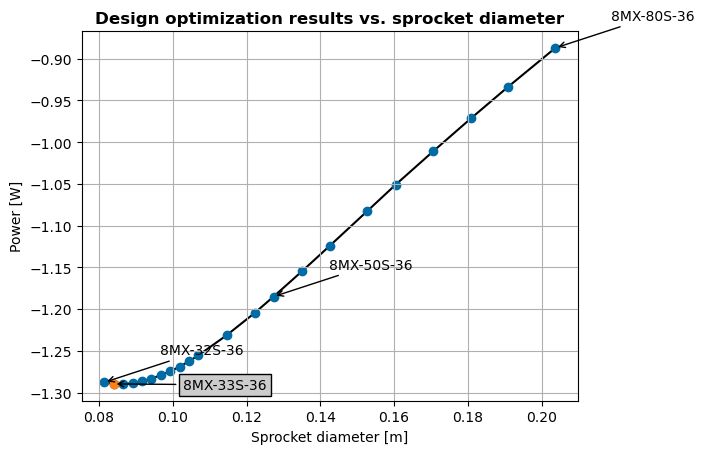

In [35]:
fvals = opt_results.fval.values
opt_x0 = np.argmin(fvals)
fig1, ax1 = plt.subplots()
ax1.grid()
ax1.plot(spr_diameters, fvals, 'k', zorder=0)
ax1.scatter(spr_diameters, fvals, zorder=1)
ax1.scatter(spr_diameters[opt_x0], fvals[opt_x0])
ax1.set_xlabel('Sprocket diameter [m]')
ax1.set_ylabel('Power [W]')
ax1.set_title('Design optimization results vs. sprocket diameter', fontweight='bold')
osu_sprockets = ['8MX-32S-36', '8MX-50S-36', '8MX-80S-36']
for i, spr in enumerate(spr_names):
    if spr in spr_names[int(opt_x0.squeeze())]:
        ax1.annotate(
            spr,
            xy=(spr_diameters[i], fvals[i]),
            xytext=(50, -3.5),
            textcoords='offset points',
            bbox=dict(boxstyle='square', fc='0.8'),
            arrowprops=dict(arrowstyle='->', facecolor='black'))
    elif spr in osu_sprockets:
        ax1.annotate(spr,
        xy=(spr_diameters[i],
        fvals[i]),
        xytext=(40, 20),
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', facecolor='black'))

Text(0, 0.5, 'Average Power (W)')

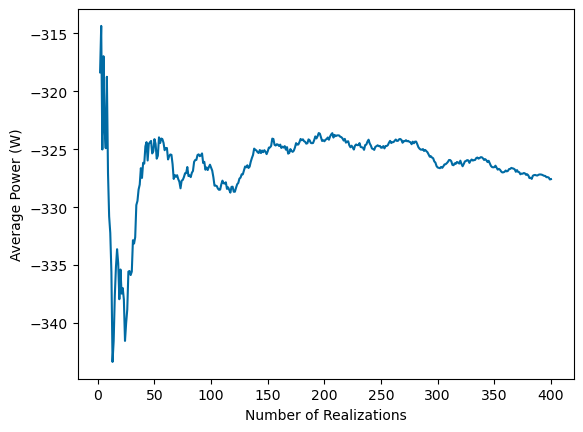